In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import rankdata

from lifelines import CoxPHFitter, KaplanMeierFitter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lifelines.utils import concordance_index
from metric import score
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
train_path = "data/train.csv"
test_path = "data/test.csv"
sample_path = "data/sample_submission.csv"
data_dict_path = "data/data_dictionary.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
data_dict_df = pd.read_csv(data_dict_path)

In [3]:
RMV = ["ID", "efs", "efs_time", "y"]
FEATURES = [c for c in train_df.columns if not c in RMV]
print(f"Total features: {len(FEATURES)} - {FEATURES}")

Total features: 57 - ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [4]:
CAT_FEATURES = []
for f in FEATURES:
    if train_df[f].dtype == "object":
        CAT_FEATURES.append(f)
        train_df[f] = train_df[f].fillna("NAN")
        test_df[f] = test_df[f].fillna("NAN")

print(f"Categorical features: {len(CAT_FEATURES)} - {CAT_FEATURES}")

Categorical features: 35 - ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']


In [5]:
CAT_SIZE = []
CAT_EMB = []
NUMS = []

combined = pd.concat([train_df,test_df],axis=0,ignore_index=True)
#print("Combined data shape:", combined.shape )

print("We LABEL ENCODE the CATEGORICAL FEATURES: ")

for c in FEATURES:
    if c in CAT_FEATURES:
        # LABEL ENCODE
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        #combined[c] = combined[c].astype("category")

        n = combined[c].nunique()
        mn = combined[c].min()
        mx = combined[c].max()
        print(f'{c} has ({n}) unique values')

        CAT_SIZE.append(mx+1) 
        CAT_EMB.append( int(np.ceil( np.sqrt(mx+1))) ) 
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")
            
        m = combined[c].mean()
        s = combined[c].std()
        combined[c] = (combined[c]-m)/s
        combined[c] = combined[c].fillna(0)
        
        NUMS.append(c)
        
train = combined.iloc[:len(train_df)].copy()
test = combined.iloc[len(train_df):].reset_index(drop=True).copy()

We LABEL ENCODE the CATEGORICAL FEATURES: 
dri_score has (12) unique values
psych_disturb has (4) unique values
cyto_score has (8) unique values
diabetes has (4) unique values
tbi_status has (8) unique values
arrhythmia has (4) unique values
graft_type has (2) unique values
vent_hist has (3) unique values
renal_issue has (4) unique values
pulm_severe has (4) unique values
prim_disease_hct has (18) unique values
cmv_status has (5) unique values
tce_imm_match has (9) unique values
rituximab has (3) unique values
prod_type has (2) unique values
cyto_score_detail has (6) unique values
conditioning_intensity has (7) unique values
ethnicity has (4) unique values
obesity has (4) unique values
mrd_hct has (3) unique values
in_vivo_tcd has (3) unique values
tce_match has (5) unique values
hepatic_severe has (4) unique values
prior_tumor has (4) unique values
peptic_ulcer has (4) unique values
gvhd_proph has (18) unique values
rheum_issue has (4) unique values
sex_match has (5) unique values
rac

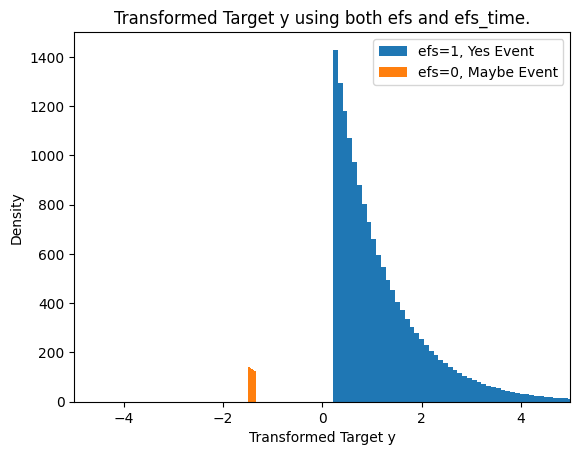

In [6]:
train["y"] = train.efs_time.values
mx = train.loc[train.efs==1,"efs_time"].max()
mn = train.loc[train.efs==0,"efs_time"].min()
train.loc[train.efs==0,"y"] = train.loc[train.efs==0,"y"] + mx - mn
train.y = train.y.rank()
train.loc[train.efs==0,"y"] += 2*len(train)
train.y = train.y / train.y.max()
train.y = np.log( train.y )
train.y -= train.y.mean()
train.y *= -1.0

plt.hist(train.loc[train.efs==1,"y"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"y"],bins=100,label="efs=0, Maybe Event")
plt.xlim((-5,5))
plt.xlabel("Transformed Target y")
plt.ylabel("Density")
plt.title("Transformed Target y using both efs and efs_time.")
plt.legend()
plt.show()

In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.out(x)

In [11]:
def train_model(model, train_loader, optimizer, num_epochs=10, verbose=True):
    model.train()
    loss_history = np.zeros((num_epochs,))
    for epoch in range(num_epochs):
        total_loss = 0
        epoch_loss = 0
        
        for data, label in train_loader:
            data, label = data.to("cuda"), label.to("cuda")
            pred = model(data)
            loss = criterion(pred, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
        avg_loss = epoch_loss / len(train_loader)
        loss_history[epoch] = avg_loss

        if verbose:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    return loss_history

In [20]:
REPEATS = 1
FOLDS = 5
EPOCHS = 5
kf = KFold(n_splits=FOLDS, random_state=10, shuffle=True)

oof_nn = np.zeros(len(train))
pred_nn = np.zeros(len(test))
loss_history = np.zeros((EPOCHS,))

for r in range(REPEATS):
    for i, (train_idx, test_idx) in enumerate(kf.split(train)):
        print("#" * 20)
        print(f"FOLD #{i+1}")
        print("#" * 20)
        
        X_train = train.drop(columns=RMV).copy().loc[train_idx].values
        y_train = train[["y"]].copy().loc[train_idx].values
    
        X_valid = train.drop(columns=RMV).copy().loc[test_idx].values
        y_valid = train[["y"]].copy().loc[test_idx].values
    
        tensor_x = torch.tensor(X_train, dtype=torch.float32)
        tensor_y = torch.tensor(y_train, dtype=torch.float32)
    
        train_dataset = TensorDataset(tensor_x, tensor_y)
        train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
    
        model = NeuralNetwork(input_dim=tensor_x.shape[1])
        model.to("cuda")
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    
        loss_history += train_model(model, train_loader, optimizer, num_epochs=EPOCHS, verbose=False)
    
        # evaluate on validate set
        tensor_x_valid = torch.tensor(X_valid, dtype=torch.float32).to("cuda")
        model.eval()
        prediction = model(tensor_x_valid)
        oof_nn[test_idx] += prediction.cpu().detach().numpy().flatten()
    
        tensor_test = torch.tensor(test.drop(columns=["ID", "efs", "efs_time"]).values, dtype=torch.float32).to("cuda")
        test_pred = model(tensor_test)
        pred_nn += test_pred.cpu().detach().numpy().flatten()
    
loss_history /= (FOLDS * REPEATS)
oof_nn /= REPEATS
pred_nn /= (FOLDS*REPEATS)

####################
FOLD #1
####################
####################
FOLD #2
####################
####################
FOLD #3
####################
####################
FOLD #4
####################
####################
FOLD #5
####################


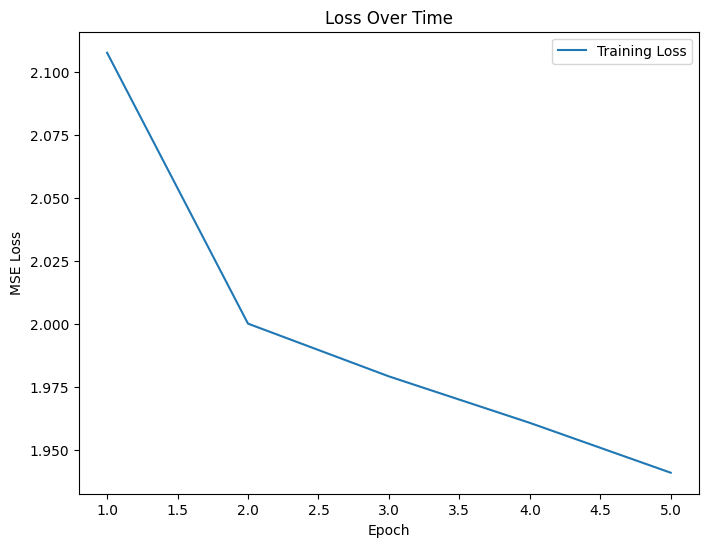

In [21]:
# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, EPOCHS+1), loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Over Time')
plt.legend()
plt.show()

In [22]:
y_true = train_df[["ID","efs","efs_time","race_group"]].copy()
y_pred = train_df[["ID"]].copy()
y_pred["prediction"] = rankdata(oof_nn)
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"Overall CV for NN =",m)

Overall CV for NN = 0.6284635389725288


In [23]:
from lifelines.utils import concordance_index

concordance_index(y_true["efs"], y_pred["prediction"], y_true["efs_time"])

0.691510089336021